In [1]:
%matplotlib inline

import numpy as np
import pandas as pd
from uncertainties import ufloat
from uncertainties import unumpy
from uncertainties.unumpy import nominal_values, std_devs
from uncertainties.umath import *
import matplotlib.pyplot as plt
from sklearn.mixture import GMM, VBGMM
from scipy.stats import norm
from scipy.optimize import curve_fit

In [2]:
run1 = pd.read_csv("/Users/Daniel/Desktop/Milikan's Oil Drop Experiment/run1.tsv", sep='\t')
run2 = pd.read_csv("/Users/Daniel/Desktop/Milikan's Oil Drop Experiment/run2.tsv", sep='\t')
print len(run2)

100


In [3]:
## Constants ##
T = 25
g = 9.807
d = ufloat(0.006, 0.05e-3)
rho = 871
eta_20 = 1.82e-5 ## Can we esitmate error using curvature?
deta_dt = 5e-8
eta = eta_20 + deta_dt*T
scale = 0.5e-3

## Measurement uncertainites ##
V_err = 3
x_err = 0.1
t_err = 0.25



def calc_q_obs(X):
    t_g, x_g, t_f, x_f, V = X[:5]
    
    t_g = ufloat(X['t_g'], t_err)
    x_g = ufloat(X['x_g'], x_err)*scale
    t_f = ufloat(X['t_f'], t_err)
    x_f = ufloat(X['x_f'], x_err)*scale
    V = ufloat(X['V'], V_err)
    
    v_g = x_g/t_g
    v_f = x_f/t_f
    
    E = V/d
    c = 6*np.pi*sqrt(4.5)*(eta**1.5)/sqrt(rho*g)
    
    return c*sqrt(v_g)*(v_g + v_f)/E


def calc_a(X):
    t_g = ufloat(X['t_g'], t_err)
    x_g = ufloat(X['x_g'], x_err)*scale
    c = 4.5*eta/(rho*g)
    return sqrt(c*x_g/t_g)

def calc_v_g(X):
    t_g = ufloat(X['t_g'], t_err)
    x_g = ufloat(X['x_g'], x_err)*scale
    return x_g/t_g

  

[ 2.24855949  4.26673453  6.23622138] [ 0.21005294  0.1979885   0.12996166]


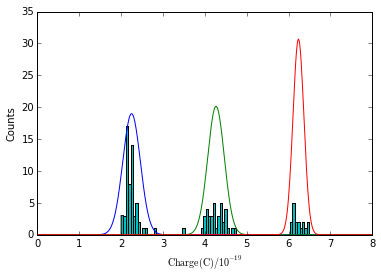

In [4]:
q = pd.concat((run1, run2)).apply(calc_q_obs, axis=1)
a = pd.concat((run1, run2)).apply(calc_a, axis=1)
v_g = pd.concat((run1, run2)).apply(calc_v_g, axis=1)

mask = [x.nominal_value < 7.5e-19 for x in q]

# Filter at n_e=3
q_filt = unumpy.uarray([x.nominal_value for x in q if x < 7.5e-19], [x.std_dev for x in q if x < 7.5e-19])
a_filt = unumpy.uarray([x.nominal_value for x in a[mask]], [x.std_dev for x in a[mask]])
vg_filt = unumpy.uarray([x.nominal_value for x in v_g[mask]], [x.std_dev for x in v_g[mask]])


mu = np.zeros(3)
sig = np.zeros(3)

mu[0], sig[0] = norm.fit([x.nominal_value*1e19 for x in q if 1.5e-19< x < 3.5e-19])
mu[1], sig[1] = norm.fit([x.nominal_value*1e19 for x in q if 3.5e-19< x < 5.5e-19])
mu[2], sig[2] = norm.fit([x.nominal_value*1e19 for x in q if 5.5e-19< x < 7e-19])

q_uncorr = unumpy.uarray(mu,sig)*1.e-19/np.array([1,2,3])
q_uncorr_diff =  [ unumpy.uarray(mu,sig)[i+1]*1.e-19 - unumpy.uarray(mu,sig)[i]*1.e-19 for i in range(2)]  

x = np.linspace(0, 8e-19, 500)*1e19
for i in range(3):
    plt.gca().plot(x, norm.pdf(x, loc=mu[i], scale=sig[i])*10)
plt.hist(nominal_values(q_filt)*1e19, bins=80, normed=False)
plt.xlabel("$\mathrm{Charge (C)}/10^{-19}$")
plt.ylabel("Counts")
#plt.savefig("GMM.pdf")

print mu,sig

[[ 22.27286544]
 [ 42.46092285]
 [ 62.36221383]]
[[[ 1.81938041]]

 [[ 5.39435059]]

 [[ 1.69000328]]]
[ 0.51327407  0.33628345  0.15044248]


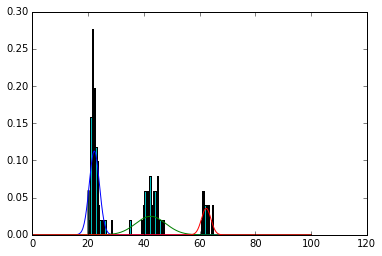

In [5]:
# Use a GMM for separating clusters
gmm = GMM(3, covariance_type="full", init_params='', tol=1e-10)

gmm.means_ = np.array([[22.5], [42], [62]])
gmm.covars_ = np.array([[[2]],[[2]],[[1.2]]])
gmm.wieghts_ = np.array([.01,0.01,1])


gmm.fit(np.reshape((nominal_values(q_filt)), (len(q_filt), 1))*1e20)
print gmm.means_ 
print gmm.covars_
print gmm.weights_


x = np.linspace(0, 10e-19, 500)*1e20
p = gmm.predict_proba(x.reshape(500,1))



for i in range(3):
    plt.gca().plot(x, gmm.weights_[i]*norm.pdf(x, loc=gmm.means_[i], scale=gmm.covars_[i][0]))
plt.hist(nominal_values(q_filt)*1e20, bins=100, normed=True)

n_e = gmm.predict(np.reshape(nominal_values(q_filt), (len(q_filt), 1))*1e20) + 1

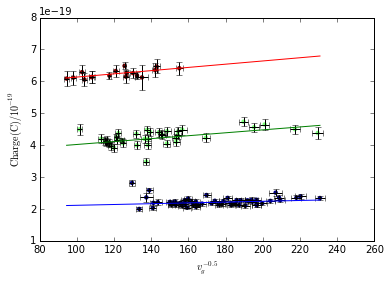

In [6]:
X = 1./np.sqrt(np.linspace(min(vg_filt).nominal_value, max(vg_filt).nominal_value, 50))
x = 1./unumpy.sqrt(vg_filt)

plt.errorbar(nominal_values(x), nominal_values(q_filt),
             xerr=std_devs(x), yerr=std_devs(q_filt), 
             linestyle="None", fmt='None', ecolor='black')

plt.scatter(nominal_values(x), nominal_values(q_filt), c=n_e-1, s=20, linewidth=0)
fits = [None, None, None]
for i in range(3):
    fits[i] = curve_fit(lambda x,a,b:a*x+b, 
                        nominal_values(x[n_e==i+1]), 
                        nominal_values(q_filt[n_e==i+1]), 
                        sigma = std_devs(q_filt[n_e==i+1]),
                        absolute_sigma=True)
    plt.plot(X, fits[i][0][0]*X+fits[i][0][1])

plt.xlabel("$v_g^{-0.5}$")
plt.ylabel("$\mathrm{Charge (C)}/10^{-19}$")

plt.savefig("Corrected1.pdf")

q_corr1 = [ufloat(fits[i][0][1], np.sqrt(fits[i][1][1,1]))/(i+1) for i in range(3)] 
q_corr1_diff = [ufloat(fits[i+1][0][1], np.sqrt(fits[i+1][1][1,1])) 
           - ufloat(fits[i][0][1], np.sqrt(fits[i][1][1,1]))  for i in range(2)]    



[2.0098066565972984e-19+/-6.800721342836305e-21, 1.792990684307775e-19+/-5.2818329775623726e-21, 1.879830269369539e-19+/-1.1771816006644414e-20]
[1.5761747120182517e-19+/-1.2563472815840801e-20, 2.0535094394930672e-19+/-3.6861523398525844e-20]


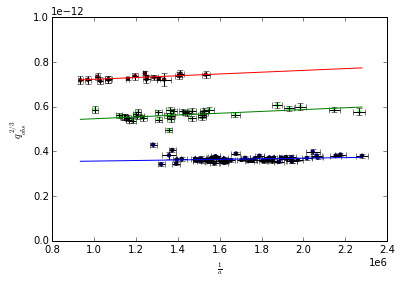

In [7]:

x = 1./a_filt
y = q_filt**(2./3)

X = np.linspace(min(x).nominal_value, max(x).nominal_value, 50)

plt.errorbar(nominal_values(x), nominal_values(y),
             xerr=std_devs(x), yerr=std_devs(y), 
             linestyle="None", fmt='None', ecolor='black')


plt.scatter(nominal_values(x), nominal_values(y), c=n_e-1, s=20, linewidth=0)

np.set_printoptions(2)
t = plt.xticks()[0]
#plt.xticks(t,  1./np.array(t))
plt.ticklabel_format(style='sci', axis='x', scilimits=(0,0))
plt.xlabel(r"$\frac{1}{a}$")
plt.ylim(0,1e-12)
plt.ylabel("$q_{obs}^{2/3}$")


fits = [0,0,0]
for i in range(3):
    fits[i] = curve_fit(lambda x,a,b:a*x+b, 
                        nominal_values(x[n_e==i+1]), 
                        nominal_values(y[n_e==i+1]), 
                        sigma = std_devs(y[n_e==i+1]),
                        absolute_sigma=True)

    plt.plot(X, fits[i][0][0]*X+fits[i][0][1])
    
plt.savefig("Corrected2.pdf")



q_corr2 = [(ufloat(fits[i][0][1], np.sqrt(fits[i][1][1,1]))**1.5)/(i+1) for i in range(3)]  
print q_corr2

q_corr2_diff = [ufloat(fits[i+1][0][1], np.sqrt(fits[i+1][1][1,1]))**1.5 
              - ufloat(fits[i][0][1], np.sqrt(fits[i][1][1,1]))**1.5  for i in range(2)] 

print q_corr2_diff

In [8]:
print "Uncorrected"
for p in  q_uncorr:
    print '{:L}'.format(p)
print np.mean(q_uncorr)

print "First order corrected"
for p in  q_corr1:
    print '{:L}'.format(p)
print np.mean(q_corr1)


print "Milikan corrected"
for p in  q_corr2:
    print '{:L}'.format(p)
print np.mean(q_corr2)

print "Ucorrected differences"
for p in  q_uncorr_diff:
    print '{:L}'.format(p)

print np.mean(q_uncorr_diff)


print "First order corrected differences"
for p in  q_corr1_diff:
    print '{:L}'.format(p)

print np.mean(q_corr1_diff)

print "Milikan corrected differences"
for p in  q_corr2_diff:
    print '{:L}'.format(p)

print np.mean(q_corr2_diff)


Uncorrected
\left(2.25 \pm 0.21\right) \times 10^{-19}
\left(2.13 \pm 0.10\right) \times 10^{-19}
\left(2.08 \pm 0.04\right) \times 10^{-19}
(2.15+/-0.08)e-19
First order corrected
\left(1.99 \pm 0.07\right) \times 10^{-19}
\left(1.78 \pm 0.06\right) \times 10^{-19}
\left(1.88 \pm 0.12\right) \times 10^{-19}
(1.88+/-0.05)e-19
Milikan corrected
\left(2.01 \pm 0.07\right) \times 10^{-19}
\left(1.79 \pm 0.05\right) \times 10^{-19}
\left(1.88 \pm 0.12\right) \times 10^{-19}
(1.89+/-0.05)e-19
Ucorrected differences
\left(2.02 \pm 0.29\right) \times 10^{-19}
\left(1.97 \pm 0.24\right) \times 10^{-19}
(1.99+/-0.19)e-19
First order corrected differences
\left(1.57 \pm 0.13\right) \times 10^{-19}
\left(2.1 \pm 0.4\right) \times 10^{-19}
(1.82+/-0.20)e-19
Milikan corrected differences
\left(1.58 \pm 0.13\right) \times 10^{-19}
\left(2.1 \pm 0.4\right) \times 10^{-19}
(1.81+/-0.19)e-19


In [9]:
np.mean(a_filt)/1e-9

678.3890539643232+/-0.8560650993447204